In [2]:
%load_ext autoreload
%autoreload 1

In [16]:
%aimport exv2.experiment_results 

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import glasbey
from matplotlib.lines import Line2D
import numpy as np


pd.set_option('display.max_columns', None)
sns.set_theme(rc={'figure.figsize':(12, 6)})
sns.set_context("paper")
sns.set_style("whitegrid")

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

palette = glasbey.create_block_palette(
    [4, 3, 3, 2, 2],
    colorblind_safe=True,
    cvd_severity=90
)
sns.set_palette(palette)

dep_focus = ["baseline_vanilla_full","monolith_feature_monolith_full","serverless_feature_serverless_full"]
ms_focus = ["baseline_vanilla_full","obs_feature_object-storage_full","norec_feature_norecommendations_full"]
lable_names = {
    "baseline_vanilla_full": "Microservices",
    'jvm_jvm-impoove_full': "Runtime Improvement",
    'monolith_feature_monolith_full': "Monolith",
    'norec_feature_norecommendations_full' : "Service Reduction",
    'obs_feature_object-storage_full' : "Infrastructure Service Replacement",
    'serverless_feature_serverless_full' : "Serverless",
    'serverless_incl_knative': "Serverless (+KNative)"
}

In [18]:
exr = exv2.experiment_results.ExperimentResults("data/clean_runs", load_stats_history=True) # type: ignore
RUN_VARS = exv2.experiment_results.ExperimentResults.RUN_VARS # type: ignore

assert("loadgenerator" not in (list(exr.pods['name'].unique())))
assert("unkown" not in (list(exr.pods['instance'].unique())))


/Users/b/projects/teastore_experiments/exv2/experiment_results.py:183: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  [self.measurement_file_to_df(pf, prefix, treat) for pf in pod_files]


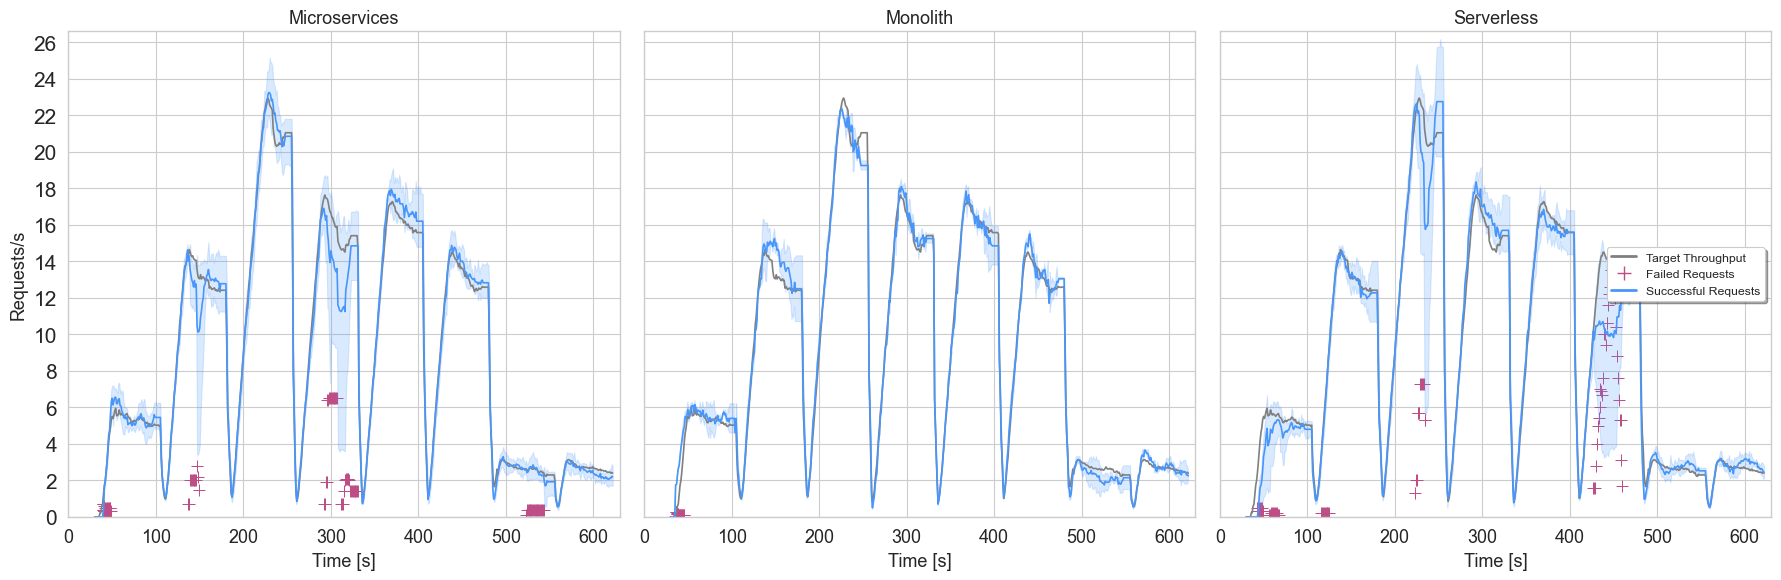

In [61]:
focus = dep_focus
wl = "exp_scale_shaped"

fig, ax = plt.subplots(1,len(focus), figsize=(18,6))
sns.set_context(rc={"font.size": 13, "axes.titlesize": 13, "axes.labelsize": 13, "xtick.labelsize": 13, "ytick.labelsize": 15})

max_rqs=exr.stats_history_aggregated[(exr.stats_history_aggregated["exp_workload"] == wl)&(exr.stats_history_aggregated["exp_branch"].isin(focus))]["rq_s"].max()
ticks = np.arange(0, int(max_rqs)+2, 2).tolist()
workload = exr.stats_history_aggregated[(exr.stats_history_aggregated["exp_workload"] == wl)]
                             
for i, branch in enumerate(focus):
    sns.lineplot(data=workload, x="run_time", y="rq_s",color="gray",errorbar=None, ax=ax[i])
    data = exr.stats_history_aggregated[(exr.stats_history_aggregated["exp_workload"] == wl)&(exr.stats_history_aggregated["exp_branch"]==branch)].copy()
    data["rq_s"] = data["rq_s"] - data["frq_s"] # remove failed requests from rq_s
    # data["timeouts"] = 0 # add column for timeouts
    # data.loc[data["p95"] > timeout,"timeouts"] = data.loc[data["p95"] > timeout,"rq_s"] # add timeouts to timeouts column
    # data["rq_s"] = data["rq_s"] - data["timeouts"] # remove timeouts from rqs
    # sns.scatterplot(data=data[data["timeouts"] > 0], x="run_time", y="timeouts",color="C9", ax=ax[i], marker="+",s=80)
    sns.scatterplot(data=data[data["frq_s"]>0], x="run_time", y="frq_s",color="C9", ax=ax[i], marker="+",s=80)
    sns.lineplot(data=data, x="run_time", y="rq_s",color="C2", ax=ax[i])
    
    ax[i].set_title(lable_names[branch])
    ax[i].set_ylabel("")
    ax[i].set_xlabel("Time [s]")
    ax[i].set_xlim(0, 630)
    ax[i].set_ylim(0, max_rqs)
    ax[i].set_yticks(ticks)
    ax[i].set_yticklabels([])
ax[0].set_ylabel("Requests/s")
ax[0].set_yticklabels(ticks)

legendShapes = [
    Line2D([0], [0], color="gray", lw=2),
    Line2D([0], [0], marker='+', lw=0,color='C9',markerfacecolor='C9', markersize=10),
    Line2D([0], [0], color="C2", lw=2),
]
legendNames = ["Target Throughput","Failed Requests","Successful Requests"]
ax[-1].legend(legendShapes, legendNames,loc="center right",fancybox=True, shadow=True, )


plt.tight_layout()

fig.savefig(f"figs/requests_{wl}.pdf", bbox_inches='tight')


